## Overview: creating a population of never-takers comparable to drug-takers
We want to sample a comparison population of never-takers such that when you form a propensity score using all recent medical history, there is apparent overlap between the propensity scores for the treated and never-treated populations.  This indicates that the never-treated **could have** taken the drug and thus could form a basis for a reasonable counterfactual.

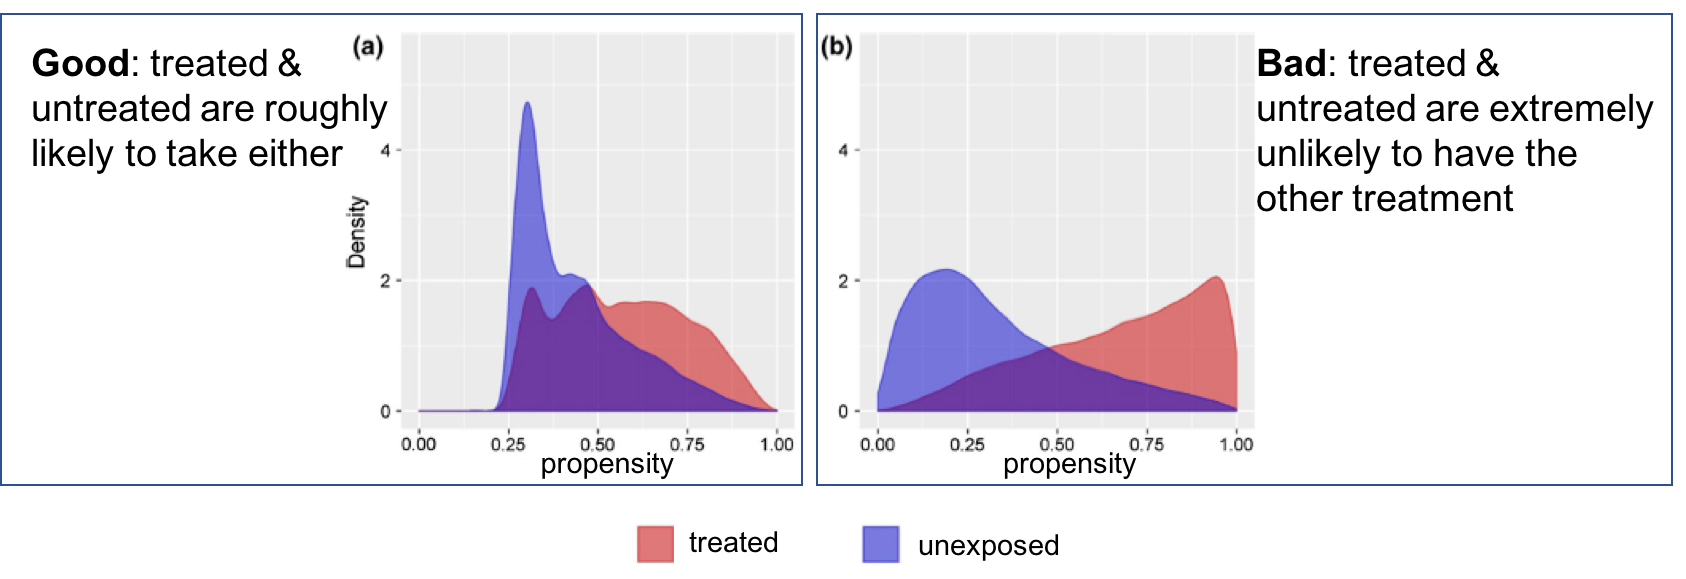

In [2]:
from IPython.display import Image 
Image(filename='png/goodbad.png',width=800)

As I mentioned, my approach to this selection is to create a simplified **summarized vector** representation of the patient histories.  This consists of two parts (approximately): 

- Diagnosis history, formed using the embeddings corresponding to Dx from the past year
- Demographic info, which is rather arbitrarily chosen, but my rough guess about what will be important.

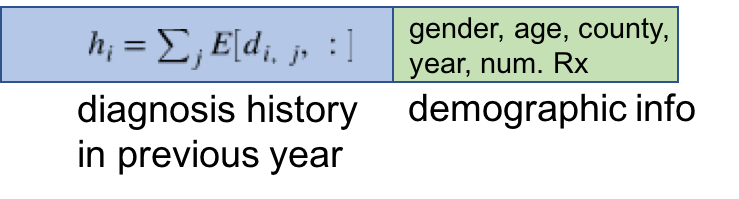

In [4]:
Image(filename='png/historyvector.png',width=400)

Then, I want to use this vector to match never-treated to treated. As as i mentioned before, I see two approaches: propensity matching and direct matching.

#### Propensity ($\hat{p}$ matching)
One way is to form a propensity score: we do aa logistic regression to predict treatment, using the summary vector as covariates. Then, we match the never-treated population to the treated, ie, using percentiles of $\hat{p}(treated | history)$. This is simple to implement (so I'll definitely try it).
- *Drawbacks*: it seems a  bit circular: our objective is to have an overlap in the propensity scores, which are also (approximately) a logistic regression on treatment given patient history and demographics.  They are regressions on two somewhat different variable sets, since the propensity score we use for effect estimation will not be based (just) on the summary vector. But it's still circular.
- *Benefits*: a supervised approach will make use of the features that are actually relevant to treatment. Imagine one variable represents a rare disease that is very relevant to prescription. This probably would not be fully exploited in the direct matching, as patients without the rare disease might be closer in other variables. 

#### Direct matching
The other way is directly **matching** never-treated patients to treated, using the summary vector, without first learning a function that relates the vector to treatment choice.
- *Drawbacks*: The unsupervised matching will be affected by differences in the distributions of the vector variables. This is why I treat the demographic and diagnosis variable separately in the two-stage matching below. Also, as mentioned above, no prioritization of variables (ie, the example of a rare disease mentioned above). 
- *Benefits*: not circular. Also, could do a better job of matching drugs with multiple indications, where some are less common (ie, prozac for IBD).

So, to use the matching approach, I need to show that it's not too impacted by the drawbacks. Or alternatively, I could show it results in a similar population to the propensity matching.

## Matching: coarsened exact demographics + nearest neighbor
I chose a few drugs to compare to each other. My general idea was that I should be able to pick people taking a comparable drug for a match, rather than people taking a drug for a totally different thing. 

Drugs chosen:
- Antidiabetic agents for type 2 diabetes: **glimiperide** and **saxagliptin** (nicknamed (`glim-diabet` and `sax-diabet`, respectively)
- Antidepressants: SSRI's **desvenlafaxine** and **trazodone** , plus Tricyclic **desipramine** (nicknamed `desve-ssri`, `traz-ssri`, and `desi-tca`)
- Antiepileptics: **phenytoin** and **levetiracetem** (a comparison pair used in [this recent OHDSI paper](http://onlinelibrary.wiley.com/doi/10.1111/epi.13828/abstract)), nicknamed `pheny-eplip` and `levet-epilep`.

For each of these drugs, I selected a sample containing of about 50k patients. For each patient, I create the demographics vector, for their first drug use. Then, I used the demgraphic info vector to bin the people. 

### Coarsened exact binning
The first step is to divide up each sample into bins of $age \times gender \times county \times year \times num. Rx$.  Of course, this is pretty arbitrary, and the coarsening is pretty arbitrary.  This is already around ~30000 possible bins (though most drugs are not evenly distributed across bins), so I'd be hesitant to bin on more variables or more finely.  

First, I looked if similar drugs have similar distributions across bins.  Below, each point is a bin (the number of points is given in the subplot title), and the axes compare the fraction of the saxagliptin sample (x-axis) in each bin, versus the fraction of one other drug (y-axis) that falls in each bin.  The left plot shows that bins with the most patients for saxagliptin also have the most patients for glimiperide. In comparison with the two antidiabetics, the correlation is lower between saxagliptin and an antiepileptic; and between saxagliptin and an antidepressant.

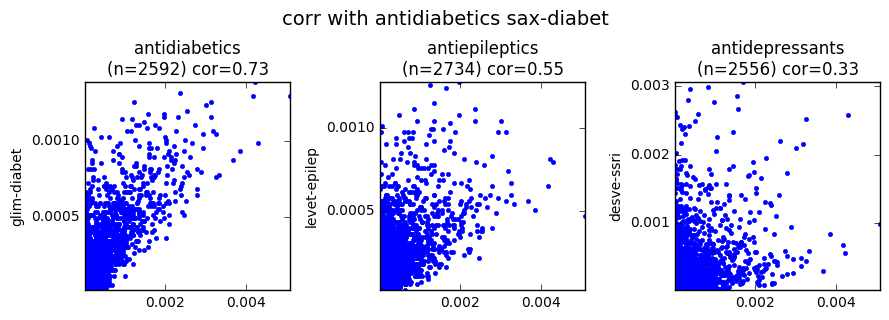

In [10]:
Image(filename='png/bin_correlation_sax.png',width=600)

(This is not normalized for the number of people in the whole population who fall in each bin.)

A big part of the discrepency between the two drugs seems to be in year of prescription. Below, I show the distribution of incident prescriptions for the two drugs, showing that while glimiperide is prescribed somewhat uniformly across most of the study period, saxagliptin is only prescribed during a few years.

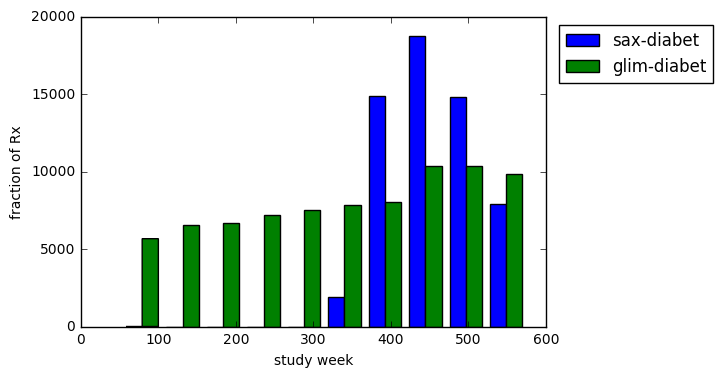

In [6]:
Image(filename='png/saxagliptin_glimiperide_studyweek.png',width=500)

If you don't bin by year, there's a much tighter correlation between the patients taking the two drugs:

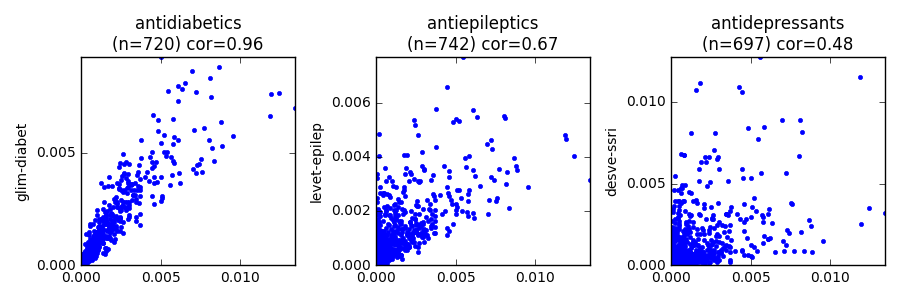

In [7]:
Image(filename='png/bin_noyearcorrelation_sax.png',width=600)

(Note that there are fewer  bins too, since we reduced the number of variables we are binning  by.)

But we will still need to correct for year at the propensity score stage, and if people only take saxagliptin in years 7-9 then I think we should only have a comparison population of people observed in yeras 7-9.  Very similar patterns show up for the other drugs. County also has a big effect.  

Overall, drugs do vary by each of the variables used in the coarsened binning. I will have to do an evaluation of how the binning choice affects the quality of the comparison population.

### Summarizing diagnosis history

I use the embeddings to summarize the diagnosis history for the past year for people in each drug-taker sample. As mentioned, given a matrix $E \in R^{num. diseases \times d} $, this history vector per patient $i$ uses the list of Dx in the past year before prescription: $h_i = \sum_{dx \in i} E[dx,:] $.  I experimented with and without an exponential decay to up-weight more recent Dx, but I'm not sure which is better. Duplicate Dx are treated as independent.

Is this vector what we would expect? I examined the population for a well-populated bin for each drug.  For example, for glimiperide, the most frequent bin was 50-60 year old males in county group 12, who took between 25 and 40 unique drugs in their history, and are observed in study year 8. This consisted of 74 patients taking glimiperide. 

We might expect the majority of patients on antidiabetics like glimperide to have a summary vector that is very similar to the type 2 diabetes vector (correlation between $h_i$ and $E[t2d,:]$ is near 1). This is sort of what we see for the diabetes drugs (left), but less so for the antidepressants (right).

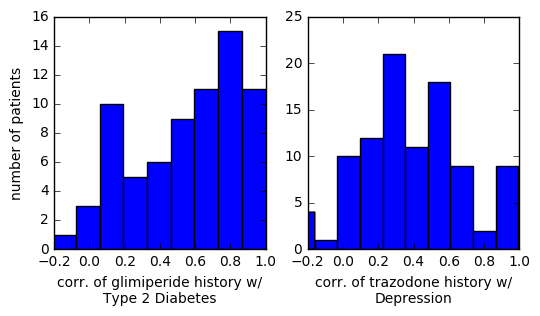

In [13]:
Image(filename='png/correlation_dx.png',width=500)

So if people on antidepressants do not have a history of depression, what does their history look like?

I looked at which diagnosis embedding the history vector was **most similar to** (highest spearman correlation).  The patients taking antidiabetics have medical histories that seem dominated by diabetes and hypertension.  People with antiepileptics and antidepressants have more diverse medical histories. 

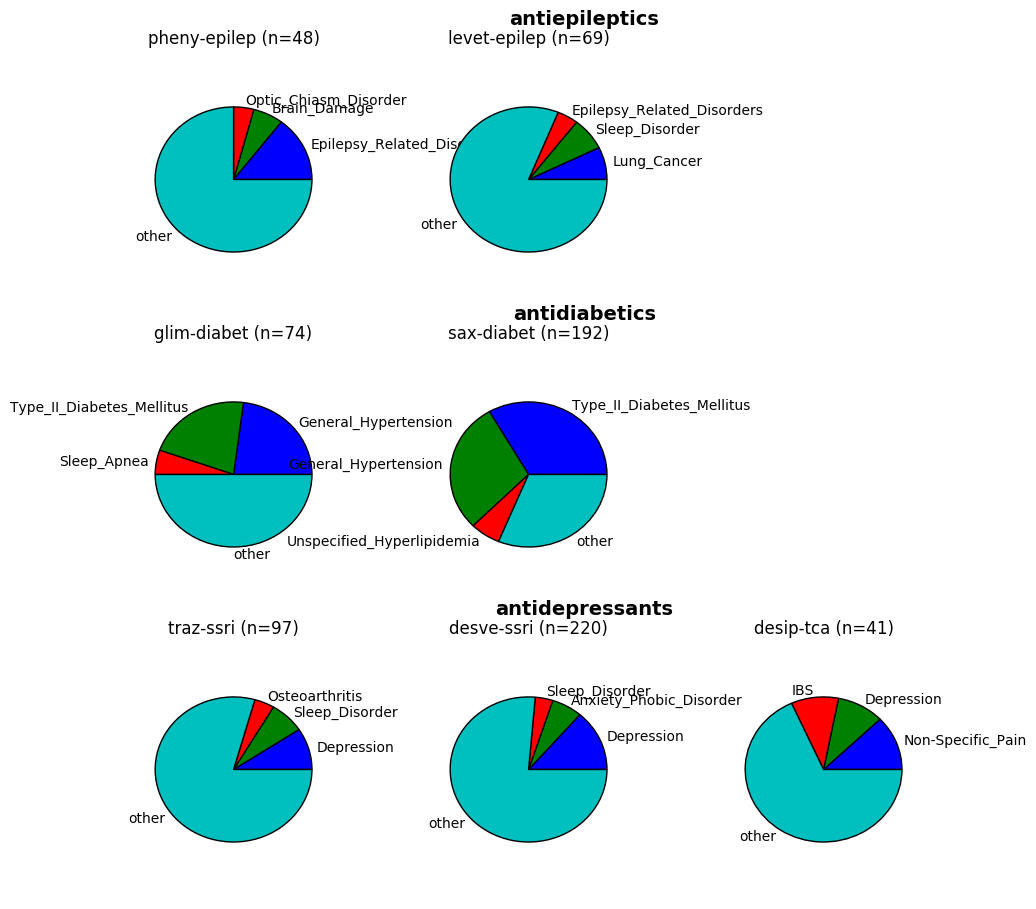

In [11]:
Image(filename='png/pie_disease.png',width=700)

So, I think this probably reflects real diversity in patients. Note that most drug comparison studies restrict to patients taking a comparison drug where patients on both drugs have a certain medical diagnosis. In the levetiracetem vs phenytoin study above, the population was restricted to epilepsy patients. Actually, the most common diagnosis among the set of 69 patients with levetiracetem is "*Administrative/social admission|Factors influencing health care*" (part of the set of Dx I need to make embeddings for).

### Matching patients within bins
Once we have assigned patients to a bin, we want to match treated patients to the most similar never-treated patients who fall in the same bin.  We would hope that patients on the one antiepileptic are matched to those on the other antiepileptic rather than the other drugs. 

I normalized the history vectors. Then, for each drug, I took patients from one big bin, such as the one described above for glimiperide that contains 74 patients. I looked at the pairwise distances between all of the 74 people in the glimiperide bin, and between these 74 people and people on saxagliptin (another antidiabetic) and on desvenlafaxine (SSRI). You can see this looks pretty nice--people on glimiperide are close to each other (smaller distance), but also close to people on saxagliptin (green bars), and people on the SSRI are farther.

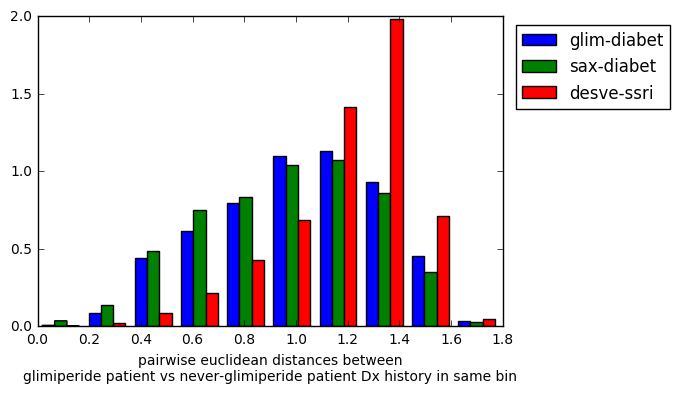

In [3]:
Image(filename='png/euclidean_diabetes.png',width=550)

However, this is not as nice for the epilepsy drug, unsurprisingly.  The phenytoin (the other epilepsy drug) and the SSRI are both kind of close to the distance of levetiracetem patients to each other. THe distances are a bit bigger. But the diabetic drug is again pretty different. 

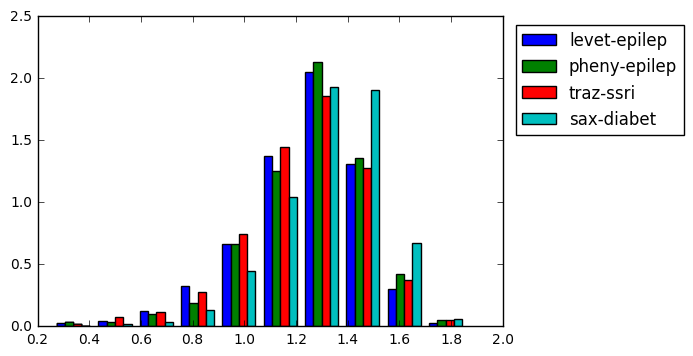

In [7]:
Image(filename='png/euclidean_epilepsy.png',width=570)

For my first matching, I tried to make a matched set for one drug (for one bin) from each of the three categories. For each drug, I just took all patients on the other drugs who fall into the same bin, and I made a one-to-one matching to minimize the total on euclidean distance between their history vectors. That is, each never-taker can only be matched to one taker. I used a maximum matching [algorithm](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.optimize.linear_sum_assignment.html)).  

So, how often are people matched to never-takers on the comparable drug? 

The figure below shows each of the three drugs we are trying to find matches for in the columns.  The rows are the sets of never-takers who that patient could be matched with.  Darker boxes indicate a larger fraction of treated were matched to people taking that drug. The antidiabetic  `glim-diabet` is usually matched to people on the other antidiabetic (`sax-diabet`), but the antiepileptic and antidepressant isnt as "successful".

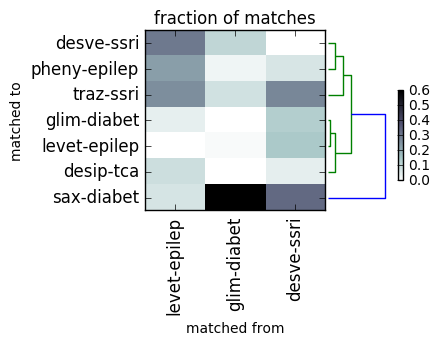

In [9]:
Image(filename='png/matching_first.png',width=500)

## Conclusions/next steps
Clearly some drugs have more complex patient sets than others. This seems promising, but I still need to do evaluations looking at the propensity score distributsion and also after getting embeddings for all diseases in history.

It should be possible to use the distribution of the history vectors for the treated set to find good matches, similar to mahalanobis matching.